In [1]:
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.python.keras.layers import Dense, Dropout, Input
from tensorflow.python.keras.models import Model

# 사전 학습된 모델 불러오기
input_tensor = Input(shape=(150,150,3))
model = VGG16(weights='imagenet', include_top=False, input_tensor = input_tensor)

In [2]:
# 모델 Layer 데이터화
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Layer 추가
x = layer_dict['block5_pool'].output
# Cov2D Layer +
x = Conv2D(filters = 64, kernel_size=(3, 3), activation='relu')(x)
# MaxPooling2D Layer +
x = MaxPooling2D(pool_size=(2, 2))(x)
# Flatten Layer +
x = Flatten()(x)
# FC Layer +
x = Dense(2048, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4, activation='softmax')(x) #

# new model 정의
new_model = Model(inputs = model.input, outputs = x)

In [3]:
# CNN Pre-trained 가중치를 그대로 사용할때
for layer in new_model.layers[:19] :
    layer.trainable = False

new_model.summary()

# 컴파일 옵션
new_model.compile(loss='sparse_categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)      

In [4]:
# 데이터 분할
train_dir ='cutf/j_train'
test_dir = 'cutf/j_test'

# 폴더에 따라 자동 분류
train_image_generator = ImageDataGenerator(
    rotation_range=40,       #회전범위
    width_shift_range=0.3,   #수평 랜덤평행이동 0.2%
    height_shift_range=0.3,  #수직 랜덤평행이동 0.2%
    rescale=1./255,          #0-1범위로 스케일링
    shear_range=0.2,         #임의 전단변환 (?)
    zoom_range=0.3,          #임의 확대축소변환
    fill_mode = 'nearest')
test_image_generator = ImageDataGenerator(
    rotation_range=40,       #회전범위
    width_shift_range=0.3,   #수평 랜덤평행이동 0.2%
    height_shift_range=0.3,  #수직 랜덤평행이동 0.2%
    rescale=1./255,          #0-1범위로 스케일링
    shear_range=0.2,         #임의 전단변환 (?)
    zoom_range=0.3,          #임의 확대축소변환
    fill_mode = 'nearest')

# 데이터 구조 생성
train_data_gen = train_image_generator.flow_from_directory(batch_size=32,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(150, 150),
                                                           class_mode='binary')

test_data_gen = test_image_generator.flow_from_directory(batch_size=32,
                                                         directory=test_dir,
                                                         target_size=(150, 150),
                                                         class_mode='binary')

Found 563 images belonging to 4 classes.
Found 202 images belonging to 4 classes.


Epoch 1/50
18/18 [==============================] - 14s 788ms/step - loss: 1.3541 - accuracy: 0.3375 - val_loss: 1.0969 - val_accuracy: 0.4901
Epoch 2/50
18/18 [==============================] - 9s 515ms/step - loss: 0.9746 - accuracy: 0.5702 - val_loss: 0.8917 - val_accuracy: 0.6535
Epoch 3/50
18/18 [==============================] - 9s 505ms/step - loss: 0.7197 - accuracy: 0.7194 - val_loss: 0.6172 - val_accuracy: 0.7228
Epoch 4/50
18/18 [==============================] - 9s 510ms/step - loss: 0.6287 - accuracy: 0.7425 - val_loss: 0.6741 - val_accuracy: 0.7475
Epoch 5/50
18/18 [==============================] - 9s 492ms/step - loss: 0.5400 - accuracy: 0.7798 - val_loss: 0.5110 - val_accuracy: 0.7921
Epoch 6/50
18/18 [==============================] - 10s 534ms/step - loss: 0.4787 - accuracy: 0.7869 - val_loss: 0.4756 - val_accuracy: 0.8069
Epoch 7/50
18/18 [==============================] - 9s 509ms/step - loss: 0.4229 - accuracy: 0.8046 - val_loss: 0.4498 - val_accuracy: 0.7772
Epoc

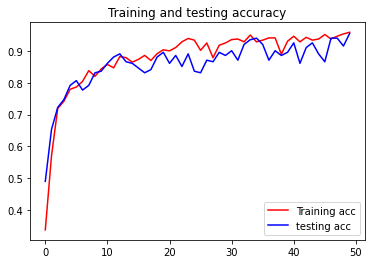

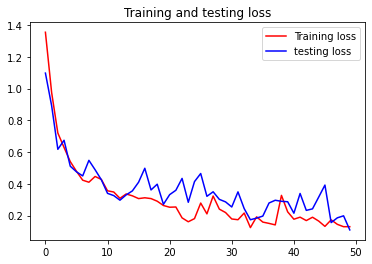

In [5]:
# 모델 학습
history = new_model.fit(train_data_gen, epochs=50,
                        validation_data=test_data_gen)

new_model.save("vgg16_handwash_joint.h5")                        
                        
# 최종 결과 리포트
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

from matplotlib import pyplot as plt

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='testing acc')
plt.title('Training and testing accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='testing loss')
plt.title('Training and testing loss')
plt.legend()

plt.show()